In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from pyod.models.knn import KNN
from sklearn.model_selection import train_test_split
from pyod.models.pca import PCA
from numpy import inf

## Table Of Content:
* [Data Cleaning](#first-bullet)
* [Feature Engineering](#second-bullet)
* [KNN](#third-bullet)
    * [KNN without groupby](#fourth-bullet)
    * [KNN after groupby "Last First" column](#fifth-bullet)
* [PCA](#sixth-bullet)
    * [PCA without groupby](#seventh-bullet)
    * [PCA with different feature engineering method](#eighth-bullet)


In [2]:
data = pd.read_csv('/Users/liangshiting/Desktop/MYSELF/purchase_credit_card.csv')

In [3]:
# the number of distribution is even throughout the time periods
sns.countplot(y = data['Year-Month'])

In [4]:
# identify the number of unique categories in each column
data.nunique()

Year-Month                         12
Agency Number                     116
Agency Name                       124
Cardholder Last Name             3911
Cardholder First Initial           38
Description                     88749
Amount                          90447
Vendor                          86729
Transaction Date                  392
Posted Date                       258
Merchant Category Code (MCC)      435
dtype: int64

In [5]:
# create a unique identifier by combining Last and First name strings
data.insert(0,
            column='Last First',
            value=data['Cardholder Last Name'] +
            data['Cardholder First Initial'])
data.head(5)

,Last First,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,MasonC,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,MasonC,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,MasseyJ,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,MasseyT,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,Mauro-HerreraM,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


In [6]:
# check the duplicate rows in the dataset
print(data.duplicated(keep=False).sum())
# check the negative values in the dataset
print(data[data["Amount"] < 0].count()[0])

22888
14531


In [7]:
# check the datatypes for each column
data.dtypes

Last First                       object
Year-Month                        int64
Agency Number                     int64
Agency Name                      object
Cardholder Last Name             object
Cardholder First Initial         object
Description                      object
Amount                          float64
Vendor                           object
Transaction Date                 object
Posted Date                      object
Merchant Category Code (MCC)     object
dtype: object

# Data Cleaning <a class='anchor' id='first-bullet'><a>


In [8]:
# convert date columns into datetime
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])
data['Posted Date'] = pd.to_datetime(data['Posted Date'])
data.head(3)

,Last First,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,MasonC,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,MasonC,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON
2,MasseyJ,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...


In [9]:
# look at the number of transaction by unique Last First
transactionnum = data.groupby("Last First").describe()["Amount"]
transactionnum.sort_values(by='count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Last First,,,,,,,,
JOURNEY HOUSE TRAVEL INCG,10137.0,289.078843,533.340907,-3136.06,20.0000,177.800,484.0000,16474.00
UNIVERSITY AMERICANG,7219.0,340.917249,870.966472,-3708.03,20.0000,244.800,500.0000,34151.60
JOURNEY HOUSE TRAVELG,4693.0,242.139874,412.521063,-1865.10,20.0000,20.000,451.0000,8286.30
HeuselJ,4212.0,304.056930,513.145126,-2676.60,46.1925,140.035,355.7175,4998.00
HinesG,3309.0,506.707579,817.430387,-1774.30,62.0000,192.360,566.0200,4999.35
BowersR,2448.0,168.346887,317.481730,-810.00,25.9750,70.190,177.8425,3855.60
TornakianM,2267.0,576.290591,873.509912,-1971.88,85.2450,234.840,647.3950,4979.00
MCDOWELLK,2112.0,272.215592,428.060450,-895.37,25.0000,121.800,435.0000,5419.15
HANNAHA,1961.0,132.561295,176.504113,-875.04,29.3800,80.460,183.9800,1633.44


Comments: There are users that that use the card very frequently. For example, Journey House Travel Incg has 10137 transactions. There are users that have only used their cards once.

In [10]:
l = []
for i in range(0, 10000, 1000):
    l.append(i)

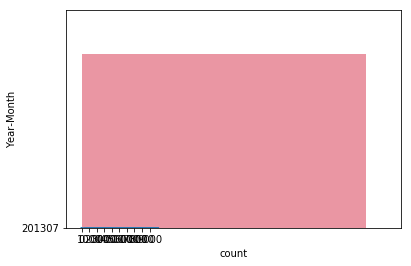

In [11]:
# show the distribution of the number of creditcard transaction groupby a unique identifer
g = sns.distplot(transactionnum['count'], bins=6, )
g.set_xticks(l)
plt.show()

Comments: Most cardholders use their card around 100-300 times. 

In [12]:
# see the range of the Transaction Date and Posted Date
print(data['Transaction Date'].describe())
print(data['Posted Date'].describe())

count                  442458
unique                    392
top       2013-09-11 00:00:00
freq                     2122
first     2013-04-17 00:00:00
last      2014-06-30 00:00:00
Name: Transaction Date, dtype: object
count                  442458
unique                    258
top       2014-01-13 00:00:00
freq                     3256
first     2013-07-01 00:00:00
last      2014-06-30 00:00:00
Name: Posted Date, dtype: object


In [13]:
# see if the transformed dataset has the same number of unique identifiers
transactionnum.reset_index(inplace=True)
transactionnum.nunique()['Last First'] == data.nunique()['Last First']

True

# Feature Engineering  <a class='anchor' id='second-bullet'><a>

# F1: 2 standard deviation from mean Amount by Merchant Category Code

In [14]:
# Group by MCC, slice by Amount
f1 = data.groupby('Merchant Category Code (MCC)').describe()['Amount']
f1.reset_index(inplace=True)
f1.head(3)

,Merchant Category Code (MCC),count,mean,std,min,25%,50%,75%,max
0,,3.0,294.360000,98.432447,180.70,265.9450,351.190,351.1900,351.19
1,"ACCOUNTING,AUDITING AND BOOKKEEPING SERVICES",94.0,833.617128,1373.092695,-585.24,121.1275,335.000,712.5300,6880.50
2,ADVANTAGE RENT A CAR,2.0,292.915000,697.087078,-200.00,46.4575,292.915,539.3725,785.83


In [15]:
# see if there's empty MCC
f1[f1['Merchant Category Code (MCC)'] == ' ']

,Merchant Category Code (MCC),count,mean,std,min,25%,50%,75%,max
0,,3.0,294.36,98.432447,180.7,265.945,351.19,351.19,351.19


In [16]:
# see the information for empty MCC cells
a = data[data.Vendor == 'THE ROOSEVELT HOTEL']
b = data[data.Vendor == 'UNIVERSITY A4657310420929']
c = pd.concat([a, b])
c

,Last First,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
94065,BeckerE,201311,18500,CORPORATION COMMISSION,Becker,E,ROOM CHARGES,351.19,THE ROOSEVELT HOTEL,2013-11-08,2013-11-11,
94071,BeckerE,201311,18500,CORPORATION COMMISSION,Becker,E,ROOM CHARGES,351.19,THE ROOSEVELT HOTEL,2013-11-08,2013-11-11,
132174,LastingerS,201310,53100,ROSE STATE COLEGE,Lastinger,S,ROOM CHARGES,1042.92,THE ROOSEVELT HOTEL,2013-10-04,2013-10-07,"LODGING--HOTELS,MOTELS,AND RESORTS"
184514,UNIVERSITY AMERICANG,201310,76000,UNIVERSITY OF OKLAHOMA,UNIVERSITY AMERICAN,G,AIR TRAVEL,180.70,UNIVERSITY A4657310420929,2013-10-10,2013-10-14,


In [17]:
# return the index where the MCC is empty
data['Merchant Category Code (MCC)'][data['Merchant Category Code (MCC)'] == " "] 

94065      
94071      
184514     
Name: Merchant Category Code (MCC), dtype: object

In [18]:
# impute the empty cells with respective MCC string
data['Merchant Category Code (MCC)'][94065] = 'LODGING--HOTELS,MOTELS,AND RESORTS'
data['Merchant Category Code (MCC)'][94071] = 'LODGING--HOTELS,MOTELS,AND RESORTS'
data['Merchant Category Code (MCC)'][184514] = 'UNIVERSITY A4657310420929'

/Users/liangshiting/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/liangshiting/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liangshiting/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd

In [19]:
# prepare the "mean Amount by MCC" chart 
f1 = data.groupby('Merchant Category Code (MCC)').describe()['Amount']
f1.reset_index(inplace=True)
f1.drop(columns=['count', 'min', '25%',
       '50%', '75%', 'max'], inplace=True)
f1.rename(columns={'mean':'MCC Mean',  'std':'MCC STD'}, inplace=True)
f1.head()

TypeError: drop() got an unexpected keyword argument 'columns'

In [ ]:
# join the mean Aount by MCC to the big dataset
data = pd.merge(data, f1, on='Merchant Category Code (MCC)')

In [ ]:
data['MCC Mean Ratio'] = (data['Amount'] - data['MCC Mean']) / data['MCC Mean'] 
data.head(3)

In [ ]:
# for those standard deviation equals to 0 , impute with 0
data['MCC STD'].fillna(value=0)
data.head(2)

In [ ]:
# define the confidence interval
def confint(mean, std, data):
    hi = mean + 1.96*std
    lo = mean - 1.96*std
    if data > hi:
        return 1
    elif data < lo:
        return 1
    else:
        return 0

In [ ]:
# run apply the function to every row
data['MCC STD Outlier'] = data.apply(lambda x:
                                    confint(x['MCC Mean'], x['MCC STD'], x['Amount']), axis=1)

In [ ]:
data.head(3)

Comment: MCC Mean Ratio cannot be used becuase there was NaN and inf values

# F2 Encode duplicate transaction with 1, else 0

In [ ]:
# find the ratio of duplicate value
data.duplicated(keep=False).sum()/data.shape[0]

In [ ]:
# encode duplicate values
data['Duplicate'] = data.duplicated(keep=False)
data.Duplicate = data.Duplicate.astype('int')
data.head(3)

# F3 Calculate the number of days between "Transaction Date" and "Posted Date"

In [ ]:
# run a for-loop to only inpute the integer value for days between Posted and Transaction Date
l = []
for i in range(len(data['Posted Date'])):
    a = data['Posted Date'][i]
    b = data['Transaction Date'][i]
    c = (a - b).days
    l.append(c)
data['Days'] = l
data.head(3)

In [ ]:
data.nunique()

# KNN  <a class='anchor' id='third-bullet'><a>

KNN standas for the Kth Nearest Neighbor. KNN assume similar things are similar to each other. To calculate the similarity, KNN uses many methodologies, one of which is the Euclidean Distance to calculate the distance. The Kth is determined by the programmer usually. The smaller the K, the higher probability the model overfits, because KNN will cluster data points more granularly. As a result, more number of clusters will appear. Usually, KNN has to be iterated several times to ensure the best number of K. 

# KNN without groupby <a class='anchor' id='fourth-bullet'><a>

In [ ]:
# run another KNN on the unpartitioned dataset
df2 = data.copy()
df2.drop(columns=['Last First','Year-Month', 'Agency Number', 'Agency Name',
       'Cardholder Last Name', 'Cardholder First Initial', 'Description',
       'Vendor', 'Transaction Date', 'Posted Date',
       'Merchant Category Code (MCC)','MCC Mean Ratio','MCC STD', 'MCC Mean'], inplace=True)
df2.head()

In [ ]:
# scale the df dataframe
df3 = df2.copy()
scaler = StandardScaler()
print(scaler.fit(df3))

In [ ]:
# modeling
clf_name = 'KNN'
clf = KNN()

In [ ]:
# fit the data
clf.fit(df3)

In [ ]:
# get the anomaly score
y_test_scores = clf.decision_scores_
y_test_scores

In [ ]:
# predict using the model
y_test_pred = clf.predict(df3)
y_test_pred

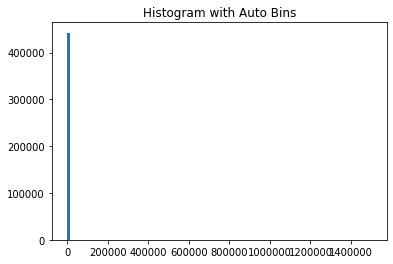

In [36]:
plt.hist(y_test_scores,bins=100)
plt.title('Histogram with Auto Bins')
# plt.ylim([0,500])
# plt.xlim([0,1e+36])
plt.show()

In [37]:
# add the cluster column to the original unscaled dataset
df2['Cluster'] = y_test_pred
df2['Anomaly Score'] = y_test_scores
df2.head(3)

,Amount,MCC STD Outlier,Duplicate,Days,Cluster,Anomaly Score
0,890.0,0,1,1,1,1.0
1,890.0,0,1,1,1,1.0
2,250.0,0,0,1,0,0.0


In [38]:
# find the count for each cluster
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))

{0: 403092, 1: 39366}

In [39]:
# showcase the results
df2 = df2.groupby('Cluster').mean()
df2.insert(0, column='Count', value=counts)
df2

,Count,Amount,MCC STD Outlier,Duplicate,Days,Anomaly Score
Cluster,,,,,,
0,403092,215.693042,0.001672,0.046101,1.773029,0.036091
1,39366,2568.119780,0.251207,0.109358,2.938627,145.330876


Comments:
For the normal cluster, it has 403,092 observations. This is the number of transactions that are classififed as normal transaction. The average spending per transaction in this cluster is '$215'. The mean MCC STD Oulier score is very small, at 0.0016, which means 99.8% of the transactions in this cluster lie within 2 standard deviations with respect to their Merchant Category Code. The duplicate score gives the number of duplicated transaction being categorized in cluster 0. On average, there is 0.046 duplicate transactions in here. Lastly, the average number of days between the "Transaction date" and the "Posted Date" is 1.77.

For Cluster 1, it has 39,366 observations, accounting for 9.8% of the population. It is certainly high, due to inability to create a more granular clustering. The average transaction amount is '$2568'. The average amount of transaction is more than 10 times the amount in Cluster 0. Interestingly, the MCC STD Outlier is also very high, it is 100 times more than that of Cluster 0, meaning the transactions in cluster 1 are frequently outside the 2 standard deviation bounds. Also, the amount of duplicate transactions in cluster 1 is also twice the amount in cluster 0. Lastly, the number of days is 2.9, which is very different from the 1.7 days in cluster 0. 

Since the KNN model follows a garbage in and garbage out theory, it has done a great job in categorizing two values due to a vastly  different anomaly score in these two clusters. However, with a limited number of numeric columns, there is a limited number of features to be used for modeling. This is one of the fallback of the model as well. 

In [40]:
df2['Count'][1]/df2['Count'][0]

0.09766008752344378

# KNN after groupby "Last First" column  <a class='anchor' id='fifth-bullet'><a>

In [41]:
ppldata = data.groupby('Last First').mean().copy()
ppldata.drop(columns=['Year-Month', 'Agency Number','MCC Mean Ratio', 'MCC STD', 'MCC Mean'], inplace=True)
ppldata.head()

,Amount,MCC STD Outlier,Duplicate,Days
Last First,,,,
150001,4626.460000,0.0,0.0,28.000000
241002,278.409000,0.0,0.0,1.100000
420004,133.998125,0.0,0.0,0.000000
446004,111.990000,0.0,0.0,1.000000
480004,96.774615,0.0,0.0,4.307692


In [42]:
# scale the data 
ppldata2 = ppldata.copy()
scaler = StandardScaler()
print(scaler.fit(ppldata2))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [43]:
# fit the data
clf.fit(ppldata2)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [44]:
# get the anomaly score
y_test_scores = clf.decision_scores_
y_test_scores

array([306.98165862,   0.84620194,   1.49924297, ...,   0.40229046,
         0.50374673,   1.25159937])

In [45]:
# get the cluster 
y_test_pred = clf.predict(ppldata2)
y_test_pred

array([1, 0, 0, ..., 0, 0, 0])

In [46]:
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))

{0: 4765, 1: 448}

In [47]:
ppldata['Cluster'] = y_test_pred
ppldata['Anomaly Scores'] = y_test_scores
ppldata.head(3)

,Amount,MCC STD Outlier,Duplicate,Days,Cluster,Anomaly Scores
Last First,,,,,,
150001,4626.460000,0.0,0.0,28.0,1,306.981659
241002,278.409000,0.0,0.0,1.1,0,0.846202
420004,133.998125,0.0,0.0,0.0,0,1.499243


In [48]:
comparison = ppldata.groupby('Cluster').mean()
comparison.insert(0, column='Count', value=counts)
comparison

,Count,Amount,MCC STD Outlier,Duplicate,Days,Anomaly Scores
Cluster,,,,,,
0,4765,233.643087,0.013528,0.040638,1.840380,0.622147
1,448,3229.044869,0.093611,0.043204,2.495354,1844.861429


Comments:
Given the above KNN ran on all observations, I want to run another model on the dataset when it is grouped by a unique identifier(person). I used "Last First" as the proxy to identify people. Then the above chart shows the result. 

For Cluster 0, it has 4765 people, the average spending is $233, and the MCC STD Outlier score is only one tenth of that in Cluster 1. However, there isn't much distinction in the Duplicate column. It is 0.04, which is similar to Cluster 1. The number of days is 1.8. 

For Cluster 1, it has 448 people, which is 9.4% of the population. The average spending is very high, it is $3229. Also, there are almost 10% of the people whose transactions would fall outside of the two standard deviations. Lastly, the number of days is also significantly different from Cluster 0. It is at 2.4. 

The model did a good job in separating the data. Cluster 0 has an anomaly score of 0.62, but Cluster 1 has an anomaly score of 1844. 

There isn't much difference when I run a KNN on all the observations versus when I run a KNN on people, except for the anomaly score. Maybe it signifies that each person's behavior is consistent and is vastly different fro others. As such, there is a larger gap between the anomaly scores.

In [49]:
comparison['Count'][1]/comparison['Count'][0]

0.09401888772298006

# PCA <a class='anchor' id='sixth-bullet'><a>
PCA is a method that transforms the existing coordinates into a new coordinates system but retain as much information as possible. By calculating the eigenvalues, a new orthogonal vectors (eigen vectors) will be established to plot the existing data points. In my exercise, my goal is to reduce the number of features and to see if there is a clear distinction between the regular data points and the outliers on a hyperplane. Then, I may categorize these data points according to their own similar group. Lastly, I will then get the final label whehther the data belongs to an outlier set. 

# PCA without groupby <a class='anchor' id='seventh-bullet'><a>

In [50]:
dfpca = data.copy()
dfpca.drop(columns=['Last First','Year-Month', 'Agency Number', 'Agency Name',
       'Cardholder Last Name', 'Cardholder First Initial', 'Description',
       'Vendor', 'Transaction Date', 'Posted Date',
       'Merchant Category Code (MCC)','MCC Mean Ratio','MCC STD', 'MCC Mean'], inplace=True)
dfpca.head()

,Amount,MCC STD Outlier,Duplicate,Days
0,890.0,0,1,1
1,890.0,0,1,1
2,250.0,0,0,1
3,108.0,0,0,1
4,54.0,0,0,1


In [51]:
# scale the data 
dfpca2 = dfpca.copy()
scaler = StandardScaler()
print(scaler.fit(dfpca2))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [52]:
dfpca2.columns

Index(['Amount', 'MCC STD Outlier', 'Duplicate', 'Days'], dtype='object')

In [53]:
# fit the model
clf_name = 'PCA'
clf = PCA()
clf.fit(dfpca2)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [54]:
dfpca2['Amount'].shape == dfpca2['MCC STD Outlier'].shape

True

Text(0.5, 1.0, 'Anomaly Scores by PCA')

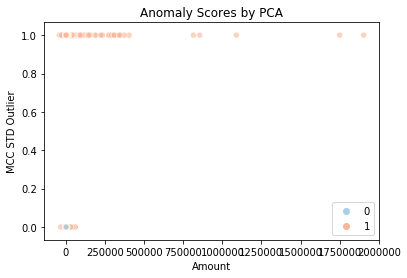

In [55]:
# tried to visualize the data
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_
sns.scatterplot(x=dfpca2['Amount'], y=dfpca2['MCC STD Outlier'], hue=clf.labels_, 
                alpha=0.6, data=dfpca2, palette='RdBu_r')
plt.title('Anomaly Scores by PCA')

Comments: <br>
For those Cluster 0, it is all 0 for MCC STD Outlier, meaning all transactions lie within the two standard deviation threshold. 

In [56]:
# predict the data
clf.predict(dfpca2)
clf.labels_

array([1, 1, 0, ..., 0, 1, 0])

In [57]:
# get the anomaly score
y_test_scores = clf.decision_scores_
y_test_scores

array([72.83661659, 72.83661659, 21.60730806, ..., 20.34751684,
       57.0293268 , 21.74522425])

In [58]:
# get the count for each cluster
unique, counts = np.unique(clf.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 398215, 1: 44243}

In [59]:
dfpca['Cluster'] = clf.labels_
dfpca['Anomaly Score'] = y_test_scores
dfpca = dfpca.groupby('Cluster').mean()
dfpca.insert(0, column='Count', value=counts)

In [60]:
dfpca

,Count,Amount,MCC STD Outlier,Duplicate,Days,Anomaly Score
Cluster,,,,,,
0,398215,295.264628,0.00000,0.000000,1.809216,19.344428
1,44243,1592.612152,0.23875,0.517325,2.484438,76.278775


Comments:
PCA provides very interesting results. Thinking in terms of the entire model, it does a better job in separation because both "MCC STD Outlier" and "Duplicate" are 0 for Cluster 0. I belive it is because the eigenvecotrs are successful in creating a higher degree of separtion. However, the difference in anomaly score isn't very high in PCA. They are not as significantly different as they were in KNN modeling. 

Cluster 0 still has the majority of the population. The average amount of spending is $295. There is no transaction in Cluster 0 that falls outside the two standard deviation nor a duplicate transaction. Lastly the days between transaction and posted is 1.8 days. 



# PCA with different feature engineering method <a class='anchor' id='eighth-bullet'><a>

In [61]:
data = pd.read_csv('/Users/liangshiting/Desktop/MYSELF/purchase_credit_card.csv')

In [62]:
data.columns

Index(['Year-Month', 'Agency Number', 'Agency Name', 'Cardholder Last Name',
       'Cardholder First Initial', 'Description', 'Amount', 'Vendor',
       'Transaction Date', 'Posted Date', 'Merchant Category Code (MCC)'],
      dtype='object')

In [63]:
# creating benchmarks
dfbench = data.groupby(['Agency Name','Merchant Category Code (MCC)'
                   ]).agg(Countbench=('Merchant Category Code (MCC)', 'count'),
                         Meanbench=('Amount','mean'),
                         Medianbench=('Amount', 'median')).reset_index().copy()
dfbench.head(3)

,Agency Name,Merchant Category Code (MCC),Countbench,Meanbench,Medianbench
0,ARDMORE HIGHER EDUCATION CENTER,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,1,115.120000,115.12
1,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,7,-53.344286,38.16
2,ARDMORE HIGHER EDUCATION CENTER,COMPUTER NETWORK/INFORMATION SERVICES,1,18.340000,18.34


In [64]:
# create the groupby dataframes
df = data.groupby(['Agency Name','Merchant Category Code (MCC)','Year-Month'
                   ]).agg(Countbym=('Merchant Category Code (MCC)', 'count'),
                         Meanbym=('Amount','mean'),
                         Medianbym=('Amount', 'median')).reset_index().copy()
df.head(3)

,Agency Name,Merchant Category Code (MCC),Year-Month,Countbym,Meanbym,Medianbym
0,ARDMORE HIGHER EDUCATION CENTER,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,201311,1,115.12,115.12
1,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201307,2,-637.75,-637.75
2,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201308,1,669.08,669.08


In [65]:
# merge the datasets
data = pd.merge(df, dfbench, how='left', on=['Agency Name','Merchant Category Code (MCC)'])
data.head(3)

,Agency Name,Merchant Category Code (MCC),Year-Month,Countbym,Meanbym,Medianbym,Countbench,Meanbench,Medianbench
0,ARDMORE HIGHER EDUCATION CENTER,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,201311,1,115.12,115.12,1,115.120000,115.12
1,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201307,2,-637.75,-637.75,7,-53.344286,38.16
2,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201308,1,669.08,669.08,7,-53.344286,38.16


In [66]:
# create ratios
data['Countratio'] = data['Countbym'] / data['Countbench']
data['Meanratio'] = data['Meanbym'] / data['Meanbench']
data['Medianratio'] = data['Medianbym'] / data['Medianbench']

In [67]:
# drop unnecessary columns
data.drop(columns=['Countbym',
       'Meanbym', 'Medianbym', 'Countbench', 'Meanbench', 'Medianbench'],inplace=True)
data.head()

,Agency Name,Merchant Category Code (MCC),Year-Month,Countratio,Meanratio,Medianratio
0,ARDMORE HIGHER EDUCATION CENTER,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,201311,1.000000,1.000000,1.000000
1,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201307,0.285714,11.955357,-16.712526
2,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201308,0.142857,-12.542674,17.533543
3,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201309,0.142857,6.271337,-8.766771
4,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201310,0.142857,-6.271337,8.766771


In [68]:
# tranpose the data
data1 = data.pivot_table(index=['Agency Name', 'Merchant Category Code (MCC)'],
                       columns='Year-Month', values='Countratio').reset_index()

In [69]:
# clean inf and -inf, impute with 0
data1.replace([np.inf, -np.inf], np.nan)
data1.fillna(value=0, inplace=True)

In [70]:
# add suffix to the column names
data1 = data1.add_suffix('Countratio')
data1.rename(columns={
    'Merchant Category Code (MCC)Countratio': 'Merchant Category Code (MCC)',
    'Agency NameCountratio': "Agency Name"},inplace=True)

In [71]:
data2 = data.pivot_table(index=['Agency Name', 'Merchant Category Code (MCC)'],
                       columns='Year-Month', values='Meanratio').reset_index()

In [72]:
data2.replace([np.inf, -np.inf], np.nan)
data2.fillna(value=0, inplace=True)

In [73]:
data2 = data1.add_suffix('Meanratio')
data2.rename(columns={
    'Merchant Category Code (MCC)Meanratio': 'Merchant Category Code (MCC)',
    'Agency NameMeanratio': "Agency Name"},inplace=True)

In [74]:
data3 = data.pivot_table(index=['Agency Name', 'Merchant Category Code (MCC)'],
                       columns='Year-Month', values='Medianratio').reset_index()

In [75]:
data3.replace([np.inf, -np.inf], np.nan)
data3.fillna(value=0, inplace=True)

In [76]:
data3 = data1.add_suffix('Medianratio')
data3.rename(columns={
    'Merchant Category Code (MCC)Medianratio': 'Merchant Category Code (MCC)',
    'Agency NameMedianratio': "Agency Name"},inplace=True)

In [77]:
# merge all that transposed datasets
data = pd.merge(data1,
                data2,
                on=["Agency Name", 'Merchant Category Code (MCC)'])
data = pd.merge(data,
                data3,
                on=["Agency Name", 'Merchant Category Code (MCC)'])

In [78]:
# create a copy
datan = data.copy()

In [79]:
# drop columns
datan.drop(columns=['Agency Name', 'Merchant Category Code (MCC)'],
          inplace=True)
datan.head()

Year-Month,201307Countratio,201308Countratio,201309Countratio,201310Countratio,201311Countratio,201312Countratio,201401Countratio,201402Countratio,201403Countratio,201404Countratio,...,201309CountratioMedianratio,201310CountratioMedianratio,201311CountratioMedianratio,201312CountratioMedianratio,201401CountratioMedianratio,201402CountratioMedianratio,201403CountratioMedianratio,201404CountratioMedianratio,201405CountratioMedianratio,201406CountratioMedianratio
0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.285714,0.142857,0.142857,0.142857,0.285714,0.000000,0.000000,0.0,0.0,0.0,...,0.142857,0.142857,0.285714,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.181818,0.090909,0.454545,0.000000,0.181818,0.090909,0.0,0.0,0.0,...,0.090909,0.454545,0.000000,0.181818,0.090909,0.0,0.0,0.0,0.0,0.0


In [80]:
# scale the data
datas = datan.copy()
scaler = StandardScaler()
print(scaler.fit(datas))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [81]:
# fit the data
clf.fit(datas)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [82]:
# get the anomaly score
y_test_scores = clf.decision_scores_
y_test_scores

array([5.63090401e+35, 2.16378960e+35, 4.92666536e+35, ...,
       5.11124233e+35, 2.98225421e+35, 4.70162977e+35])

In [83]:
# predict using the model
y_test_pred = clf.predict(datas)
y_test_pred

array([1, 0, 0, ..., 0, 0, 0])

In [84]:
# add the cluster column to the original unscaled dataset
datan['Cluster'] = y_test_pred
datan['Anomaly Score'] = y_test_scores
datan.head(3)

Year-Month,201307Countratio,201308Countratio,201309Countratio,201310Countratio,201311Countratio,201312Countratio,201401Countratio,201402Countratio,201403Countratio,201404Countratio,...,201311CountratioMedianratio,201312CountratioMedianratio,201401CountratioMedianratio,201402CountratioMedianratio,201403CountratioMedianratio,201404CountratioMedianratio,201405CountratioMedianratio,201406CountratioMedianratio,Cluster,Anomaly Score
0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5.630904e+35
1,0.285714,0.142857,0.142857,0.142857,0.285714,0.0,0.0,0.0,0.0,0.0,...,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.163790e+35
2,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.926665e+35


In [85]:
# find the count for each cluster
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))

{0: 7595, 1: 832}

In [86]:
# showcase the results
datan = datan.groupby('Cluster').mean()
datan.insert(0, column='Count', value=counts)
datan

Year-Month,Count,201307Countratio,201308Countratio,201309Countratio,201310Countratio,201311Countratio,201312Countratio,201401Countratio,201402Countratio,201403Countratio,...,201310CountratioMedianratio,201311CountratioMedianratio,201312CountratioMedianratio,201401CountratioMedianratio,201402CountratioMedianratio,201403CountratioMedianratio,201404CountratioMedianratio,201405CountratioMedianratio,201406CountratioMedianratio,Anomaly Score
Cluster,,,,,,,,,,,,,,,,,,,,,
0,7595,0.092084,0.069824,0.097719,0.104465,0.059453,0.046266,0.062101,0.060596,0.095331,...,0.104465,0.059453,0.046266,0.062101,0.060596,0.095331,0.104479,0.101003,0.106677,2.846874e+35
1,832,0.000120,0.236779,0.000120,0.000000,0.210670,0.167643,0.195913,0.188678,0.000075,...,0.000000,0.210670,0.167643,0.195913,0.188678,0.000075,0.000000,0.000000,0.000000,5.679270e+35


Comments:
Even after a new round of feature engineering, I still have a cluster 1 that is about 10% of the population. Each column here signifies the ratio at a different Year-Month. Most of the variables are different significantly. One interesting note is that the anomaly scores are not very different from each other. It is not as far away as my previous models had developed. 

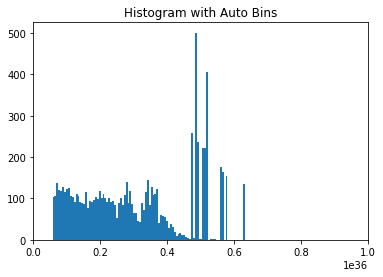

In [87]:
plt.hist(y_test_scores,bins=100)
plt.title('Histogram with Auto Bins')
# plt.ylim([0,500])
plt.xlim([0,1e+36])
plt.show()

Comment:
I was expecting a chart similar to that we saw in class. However, out output looks very interesting. A high frequency of anomaly scores appear to be between 0.4 and 0.6. 

# Conclusion <br>
In this exercise, I had tried multiple feature engineering methods. I first feature engieered to the whole dataset, then I feature engieered by "Last Frist". Lastly, I created time-series-like features for modeling. I probably had a bug somewhere that inhibited me from graphing the anomaly scores. As such, I could not define the threshold. However, I really like the PyOD package, especially the many methods that come along with it. 